# Import Dependencies

In [37]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam
import monai
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor
import torch.nn.functional as F
from monai.losses import DiceLoss


# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator


# MedSAM
from transformers import SamModel, SamProcessor, SamConfig

from segment_anything import sam_model_registry
from MedSAM.utils.demo import BboxPromptDemo



2.6.0+cu126
True


## Gather data for each split

In [31]:
importlib.reload(image_mask_dataset)

# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test", processor)
train_dataset = ImageMaskDataset(dataset_path, "train", processor)
valid_dataset = ImageMaskDataset(dataset_path, "valid", processor)



test_dataset[0]["pixel_values"].shape

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 157/157 [00:00<00:00, 9850.50it/s]


(640, 640, 3)

# Base Model Evaluation

### Initialise MedSAM Model

In [8]:
MedSAM_checkpoint = "Models/medsam_vit_b.pth"

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_checkpoint)
medsam_model = medsam_model.to("cuda")
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


### Box Prompt Inference Example

### Box Prompt Inference Demo

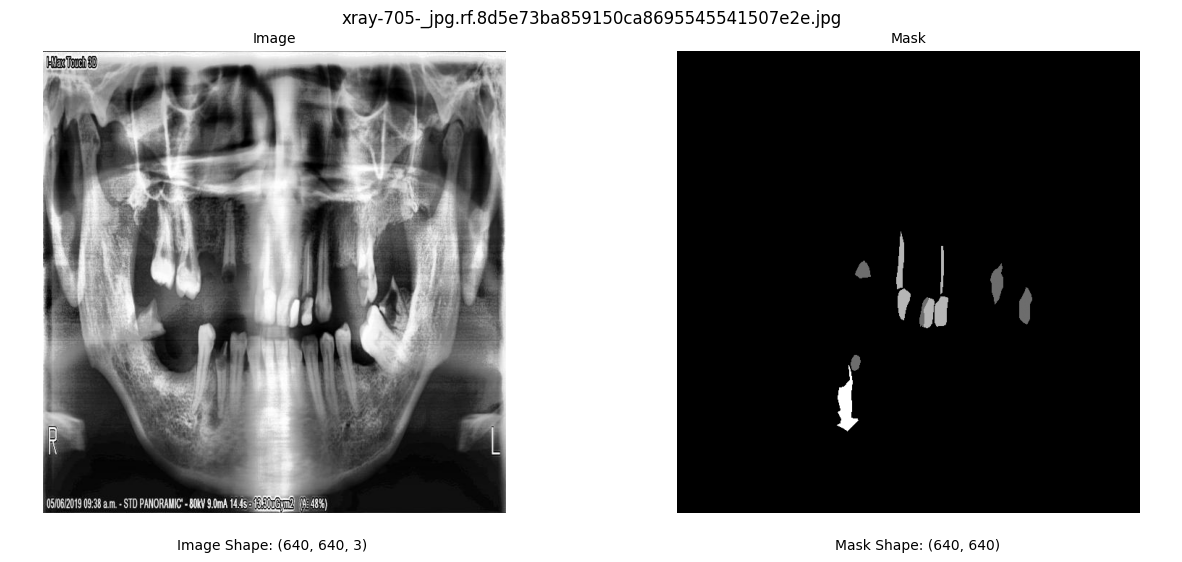

Button(description='clear', style=ButtonStyle())

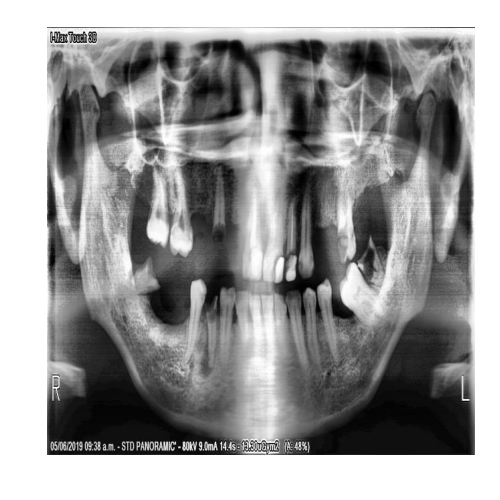

Button(description='save', style=ButtonStyle())

No such comm: 74ba668096a140609dedefba6da3c91c


In [25]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)
image = test_dataset.image_mask_pairs[image_idx][0]

# Display image
%matplotlib inline
test_dataset.show_image_mask(image_idx)

# Segment image
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(image)


In [ ]:
%matplotlib inline

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


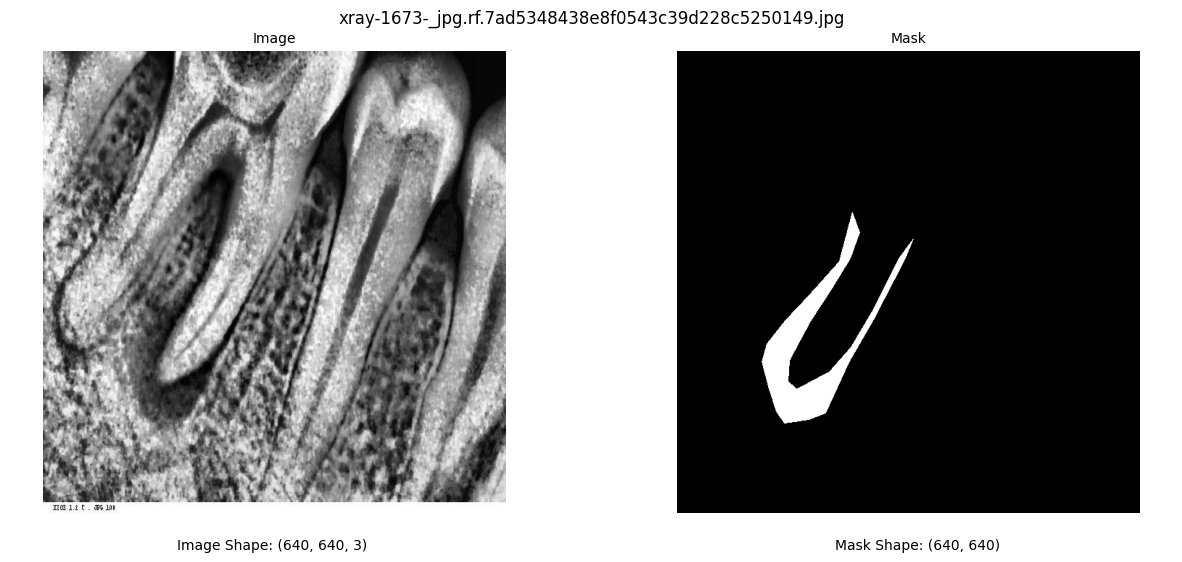

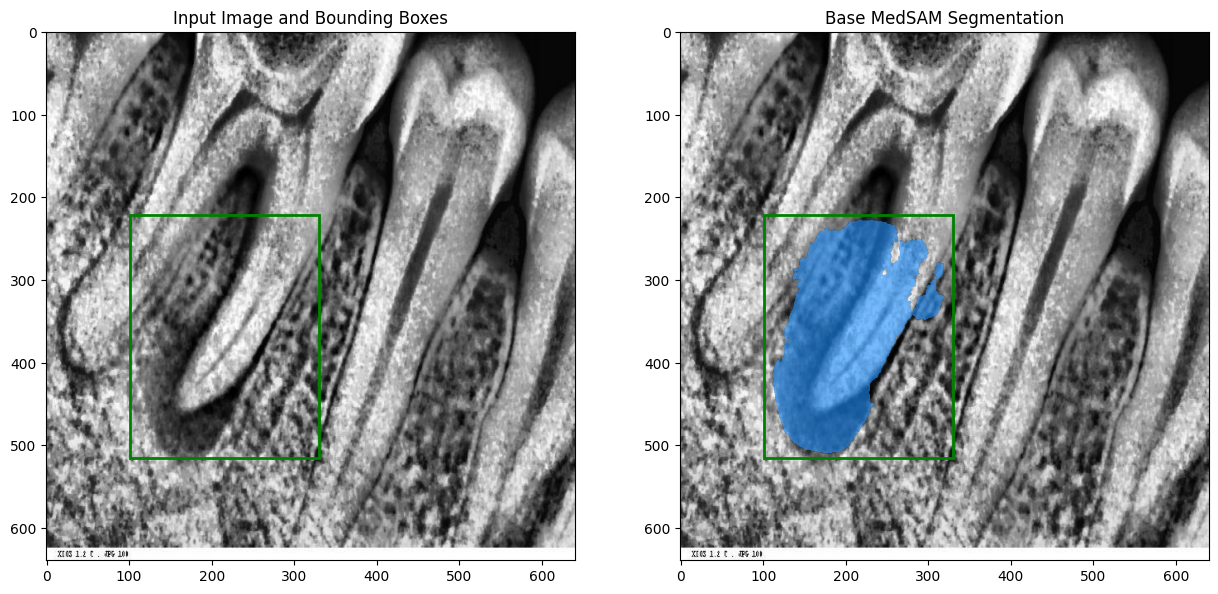

In [38]:

importlib.reload(model_evaluator)
evaluator = ModelEvaluator(medsam_model, processor, test_dataset)


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True

# Load random image
#image_idx = random.randint(0, len(test_dataset)-1)

image_idx = 33

# Get tensors
img_np, box_np, gt_masks, bounding_boxes = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape

# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_np)


# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = evaluator.medsam_inference(image_embedding, box_np, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))


if len(seg_masks.shape) == 2:
    seg_masks = [seg_masks]


# Original image with bounding boxes
ax[0].imshow(img_original)
for box in bounding_boxes:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(bounding_boxes, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1]) # random_colour = True
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

### MedSAM Base Model Evaluation

In [39]:
results = evaluator.evaluate_medsam_model()
evaluator.print_results()

Evaluating MedSAM: 100%|██████████| 82/82 [01:36<00:00,  1.17s/it]

IoU: 0.4271
Precision: 0.4676
Recall: 0.8134
F1 Score: 0.5541
Dice Score: 0.5541
MCC: 0.5911
